我们先导入一点包

In [ ]:
import math
from collections import OrderedDict
import torch.nn as nn

## 这是一篇有关YOLOv3的详细网络解释

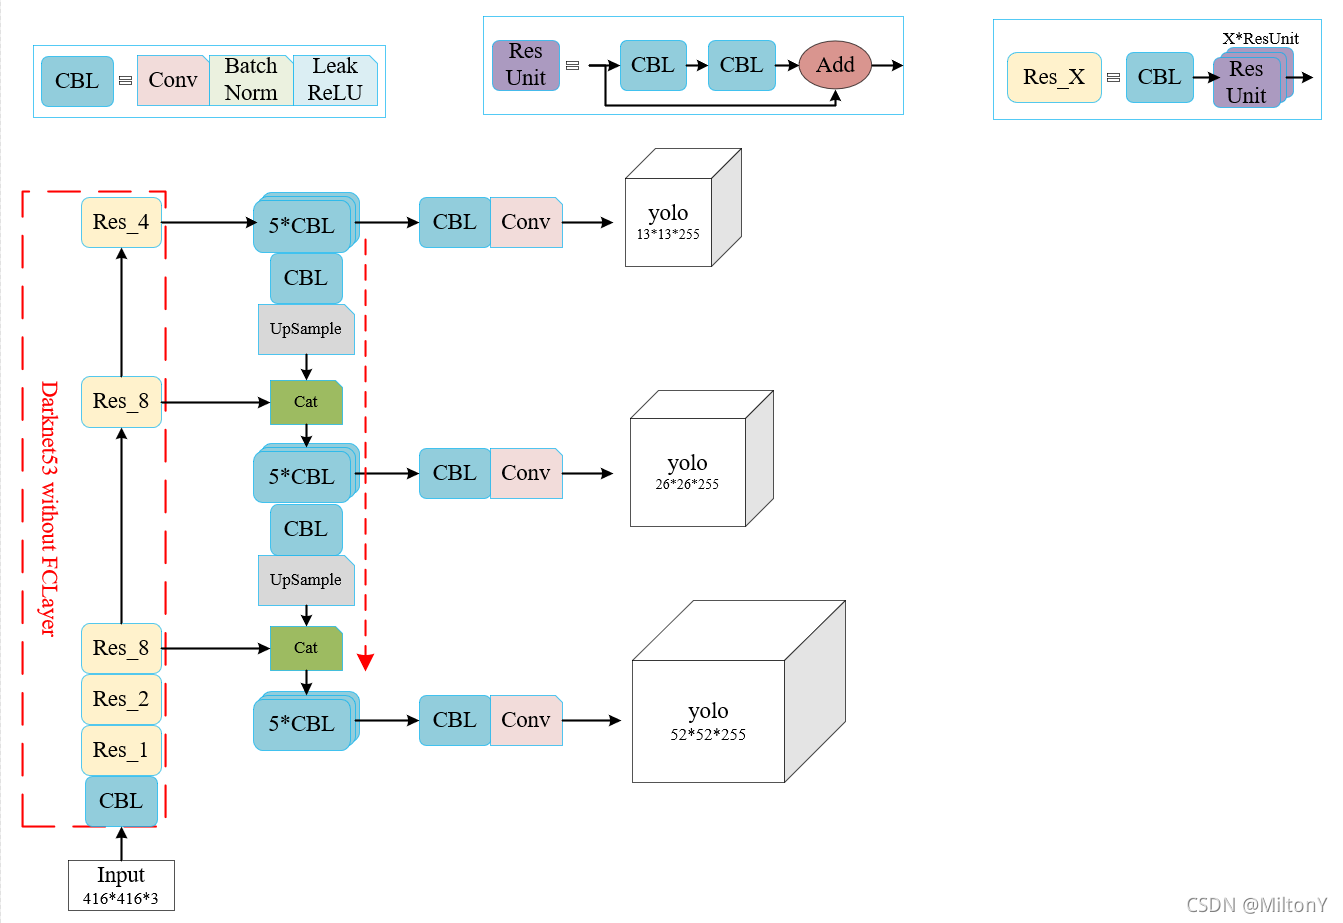

TODO:
backbone
neck
head

### Yolo v3的backbone

我们可以看到,这里yolo v3的backbone采用了Darknet53,这是一个包含53层conv层的骨干网络
在这个仓库的/nets/darknet你可以看到有关这个模型的具体定义,接下来我们从小到大将这个模型梳理一遍

#### Darknet 里头的 BasicBlock
BasicBlock是Darknet里头最基础的模块,使整个模型中用于构建和复用的基础模块
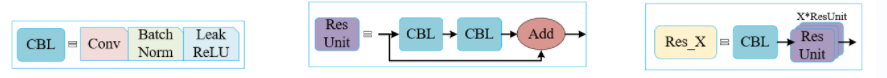
如图中的Res_X表示,X的数字表示这一层中BasicBlock得到个数,首先让我们依次对这个模型进行拆解
CBL是指Conv+ Batch_Norm+ LeakyReLU,三层构成的层,分别是卷积,用于正则化的BN,激活函数LeakyReLU


```python
self.conv1 = nn.Conv2d(inplanes,
                       planes[0],
                        kernel_size=1,
                        stride=1,
                        padding=0,
                        bias=False)
self.bn1 = nn.BatchNorm2d(planes[0])
self.relu1 = nn.LeakyReLU(0.1)
#这里就是两个CBL层,用于构成之后的Res_Unit
self.conv2 = nn.Conv2d(planes[0],
                       planes[1],
                       kernel_size=3,
                       stride=1,
                       padding=1,
                       bias=False)
self.bn2 = nn.BatchNorm(planes[1])
self.relu2 = nn.LeakyReLU(0.1)
```

接下来是Res_Unit层
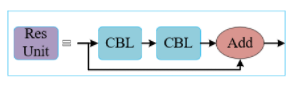
```python
def forward(self,x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        
        out += residual
        return out 
```
我们将两个CBL叠加,并且在最后进行了残差链接



### DarkNet的构成
ResUnit的构成我们已经了解了,接下来是Res_X
我们来看看DarkNet的源代码

```python
class Darknet(nn.Module):
    def __init__(self,layers):
        super(Darknet,self).__init__()
        self.inplanes = 32
        # channel 3 ->32
        self.conv1 = nn.Conv2(3 ,self.inplanes,kernel_size=3,stride=1,padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu1 = nn.LeakyReLU(0.1)
```

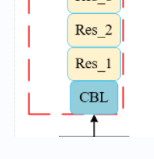

这是最开始的CBL,会将整个输入图的channel放大到32

#### Res_X的构建

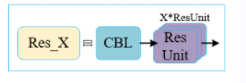


接下来是Res_X,我们会创建一个_make_layer的函数,用于创建Res_X

```python
    def _make_layer(self,planes,blocks):#planes是一个数组,block是一个数字
        layers = []
        layers.append(("ds_conv",nn.Conv2d(self.inplanes,
                                           planes[1],
                                           kernel_size= 3,
                                           stride= 2,
                                           padding=1,
                                           bias=False))) 
        layers.append(("ds_bn",nn.BatchNorm2d(planes[1])))
        layers.append(("ds_relu",nn.LeakyReLU(0.1)))
```

上面的代码是用来创建每一个Res_X中前面的CBL,将将创建完成的层都存储到layers[]这个变量里头去

```python        
        #residual
        self.inplanes = planes[1]
        for i in range(0,blocks):
            layers.append(("residual_{}",format(i),BasicBlock(self.inplanes,planes)))#注意看,这里调用了我们之前创建的BasicBlock
        return nn.Sequential(OrderedDict(layers))
```

其中,block会作为传入值,用于定义ResUnit的个数,例如Res_4就是包含四个Res_Unit

在第一步添加完CBL之后紧接着添加我们之前制定的Res_Unit,最后返回我们完整定义的Res_X

```python        
        # 416,416,32 -> 208,208,64
        self.layer1 = self._make_layer([32, 64],layers[0])
        # 208,208,64 -> 104,104,128
        self.layer2 = self._make_layer([64, 128],layers[1])
        # 104,104,128 -> 52,52,256
        self.layer3 = self._make_layer([128, 256],layers[2])
        # 52,52,256 -> 26,26,512
        self.layer4 = self._make_layer([256, 512],layers[3])
        # 26,26,512 - 13,13,1024
        self.layer5 = self._make_layer([512, 1024],layers[4])
        
        self.layers_out_filters = [64, 128, 256, 512, 1024]
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):#判断n是不是Conv layer
                n = m.kernel_size[0]*m.kernel_size[1]* m.out_channels
                m.weight.data.normal_(0,math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
```

```python
    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        out3 = self.layer3(x)
        out4 = self.layer4(out3)
        out5 = self.layer5(out4)
        
        return out3, out4, out5
```

最后我们将DarkNet中的倒数三二一层结果作为输出返回

## YOLO V3


紧接着是ResUnit